<a href="https://colab.research.google.com/github/lejejefr/ECM_2526_FinalProject/blob/main/Sripts/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ce script sert à entrainer notre modèle et à l'utiliser s'il est déjà entrainé


In [2]:
#ce bloc sert à installer les packages python dont nous avons besoin
!pip install pandas numpy scikit-learn matplotlib

In [32]:
#dans ce bloc, nous installons les différentes bibliothèques dont nous aurons besoin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.neighbors import KernelDensity

In [4]:
# cette fonction calcule l'aire d'une zone rectangulaire en fonction des coordonnées des bords
#lat1, lat2, lon1 et lon2 sont respectivement les latitudes et longitudes des côtés de la zone observée.
#la fonction renvoit une aire en km2

def area(lat1, lat2, lon1, lon2, R = 6378):
    lat1 = np.pi * lat1 / 180.0
    lat2 = np.pi * lat2 / 180.0
    lon1 = np.pi * lon1 / 180.0
    lon2 = np.pi * lon2 / 180.0

    h = max(np.sin(lat1), np.sin(lat2)) - min(np.sin(lat1), np.sin(lat2))
    r = (max(lon1, lon2) - min(lon1,lon2)) / (2 * np.pi)

    return 2 * np.pi * (R ** 2) * h * r

print(area(41.644818,42.022548,-87.904123,-87.525759))
#-->le rectangle couvert par les données est de 1319.5307651175892km2, soit environ 2 fois l'air de chicago. Si on regarde une carte de la ville, on voit que le plus petit
#rectangle contenant la ville peut la contenir à peu près 2 fois, donc a priori la fonction calculant l'aire en fonction des coordonnées fonctionne bien.

1319.5307651175892


In [5]:
#ce bloc permet d'importer la base de donnée propre
url = "https://raw.githubusercontent.com/lejejefr/ECM_2526_FinalProject/refs/heads/main/Data/CleanData.csv"
df = pd.read_csv(url)
#la ligne suivante sert uniquement à vérifier que la base de données a bien été importée
df.describe()
#-->

,ID,time,day of week,day of year,latitude,longitude
count,1.394000e+04,13940.000000,13940.000000,13940.00000,13937.000000,13937.000000
mean,8.288289e+04,44380.933931,3.230273,190.47231,41.817290,-87.668187
std,8.602471e+05,27943.989010,2.061345,97.01024,0.078640,0.057413
min,6.340000e+02,0.000000,0.000000,1.00000,41.644818,-87.904123
25%,4.157750e+03,15780.000000,1.000000,115.75000,41.757257,-87.714760
50%,2.178050e+04,48600.000000,3.000000,192.00000,41.803585,-87.665192
75%,2.541325e+04,69960.000000,5.000000,268.00000,41.880778,-87.624568
max,1.373461e+07,86340.000000,6.000000,366.00000,42.022548,-87.525759


In [6]:
len(df)
#-->13940

13940

Dans cette partie, on a essayé de mettre en place une random forest pour évaluer le nombre de meutres au voisinage du point étudié


In [7]:
#ce bloc permet de générer des données labélisées utilisables pour l'entraînement et le test
min_lat = 41.644818
max_lat = 42.022548

min_long = -87.904123
max_long = -87.525759

min_time = 0.0
max_time = 86340.0

space_division = 50
time_division = 24

latitude_span = (max_lat - min_lat) / space_division
longitude_span = (max_long - min_long) / space_division
time_span = (max_time - min_time) / time_division

def calculate_density(row):
  lat_center = row["latitude"]
  lon_center = row["longitude"]
  time_center = row["time"]
  dow = row["day of week"]
  doy = row["day of year"]

  lat_min_zone = max(lat_center - latitude_span/2, min_lat)
  lat_max_zone = min(lat_center + latitude_span/2, max_lat)

  lon_min_zone = max(lon_center - longitude_span/2, min_long)
  lon_max_zone = min(lon_center + longitude_span/2, max_long)

  time_min_zone = max(time_center - time_span/2, min_time)
  time_max_zone = min(time_center + time_span/2, max_time)
  subset = df[
      (df["latitude"].between(lat_min_zone, lat_max_zone)) &
      (df["longitude"].between(lon_min_zone, lon_max_zone)) &
      (df["time"].between(time_min_zone, time_max_zone))
      #(df["day of week"] == dow) &
      #(df["day of year"] == doy)
      ]
  count = len(subset)
  volume = ((time_max_zone - time_min_zone) / 3600) * area(lat_min_zone,lat_max_zone,lon_min_zone,lon_max_zone)
  if volume <= 0.00001:
    return 0
  return count




labeled_df = pd.DataFrame({
    "latitude": np.random.uniform(min_lat, max_lat, 15000),
    "longitude": np.random.uniform(min_long, max_long, 15000),
    "time": np.random.uniform(0.000000, 86340.000000, 15000),
    "day of week": np.random.randint(0, 6, 15000),
    "day of year": np.random.randint(1, 366, 15000),
})
labeled_df["density"] = labeled_df.apply(calculate_density, axis = 1)

labeled_df.describe()

,latitude,longitude,time,day of week,day of year,density
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,41.833819,-87.715871,43326.599735,2.503867,183.743733,0.236533
std,0.108732,0.109133,25042.815434,1.708151,105.815324,0.768695
min,41.644839,-87.904122,3.608107,0.000000,1.000000,0.000000
25%,41.740061,-87.810240,21674.319993,1.000000,92.000000,0.000000
50%,41.833509,-87.715950,43177.803548,3.000000,182.000000,0.000000
75%,41.928170,-87.621519,65320.976933,4.000000,276.000000,0.000000
max,42.022535,-87.525764,86335.593485,5.000000,365.000000,10.000000


In [8]:
labeled_df.describe()

,latitude,longitude,time,day of week,day of year,density
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,41.833819,-87.715871,43326.599735,2.503867,183.743733,0.236533
std,0.108732,0.109133,25042.815434,1.708151,105.815324,0.768695
min,41.644839,-87.904122,3.608107,0.000000,1.000000,0.000000
25%,41.740061,-87.810240,21674.319993,1.000000,92.000000,0.000000
50%,41.833509,-87.715950,43177.803548,3.000000,182.000000,0.000000
75%,41.928170,-87.621519,65320.976933,4.000000,276.000000,0.000000
max,42.022535,-87.525764,86335.593485,5.000000,365.000000,10.000000


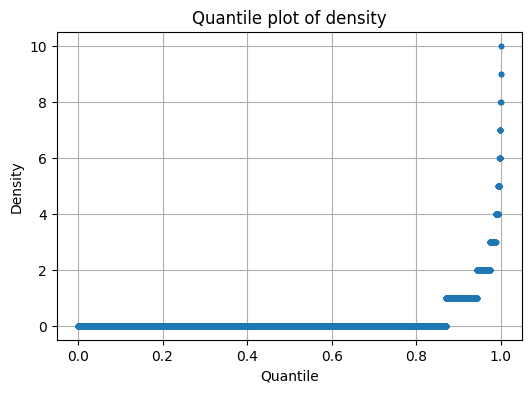

In [9]:
# Trier les données
sorted_density = np.sort(labeled_df["density"])

# Calculer les quantiles (0 à 1)
quantiles = np.arange(1, len(sorted_density)+1) / len(sorted_density)

# Plot
plt.figure(figsize=(6,4))
plt.plot(quantiles, sorted_density, marker='.', linestyle='none')
plt.xlabel("Quantile")
plt.ylabel("Density")
plt.title("Quantile plot of density")
plt.grid(True)
plt.show()

In [11]:
#lat_bin = pd.cut(labeled_df["latitude"], bins=10, labels=False)
#lon_bin = pd.cut(labeled_df["longitude"], bins=10, labels=False)
#time_bin = pd.cut(labeled_df["time"], bins=6, labels=False)

density_bin = pd.cut(labeled_df["density"], bins=3, labels=False)

#strat = lat_bin.astype(str) + "_" + lon_bin.astype(str) + "_" + time_bin.astype(str) + "_" + density_bin.astype(str)

X = labeled_df.drop('density',axis = 1)
Y = labeled_df['density']

print(len(X))
print(len(Y))
print(len(density_bin))

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=None
)
print(X_train.describe())
print(X_test.describe())
print(Y_train.describe())
print(Y_test.describe())

15000
15000
15000
           latitude     longitude          time   day of week   day of year
count  12000.000000  12000.000000  12000.000000  12000.000000  12000.000000
mean      41.834134    -87.716404  43159.478425      2.505583    184.258750
std        0.108776      0.109163  25107.033942      1.707350    105.945106
min       41.644839    -87.904122      9.030701      0.000000      1.000000
25%       41.740975    -87.811080  21395.170899      1.000000     92.000000
50%       41.833719    -87.716725  42853.517911      3.000000    183.000000
75%       41.928494    -87.622404  65299.643897      4.000000    277.000000
max       42.022535    -87.525764  86335.593485      5.000000    365.000000
          latitude    longitude          time  day of week  day of year
count  3000.000000  3000.000000   3000.000000  3000.000000  3000.000000
mean     41.832557   -87.713739  43995.084976     2.497000   181.683667
std       0.108566     0.109007  24777.157418     1.711617   105.286995
min      4

In [27]:
rf = RandomForestRegressor()
rf.fit(X_train,Y_train)

RandomForestRegressor()

In [28]:
Y_pred = rf.predict(X_test)
print(Y_pred)

[0.48 0.   0.28 ... 0.   0.45 0.43]


In [29]:
prediction_dataframe = pd.DataFrame({
    'prediction': Y_pred
})

error_df = pd.DataFrame()
print(Y_test.describe())
error_df["error"] = (Y_pred - Y_test)**2
print(error_df.describe())

count    3000.000000
mean        0.240667
std         0.774347
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: density, dtype: float64
             error
count  3000.000000
mean      0.360703
std       1.864279
min       0.000000
25%       0.000000
50%       0.000000
75%       0.057600
max      49.843600


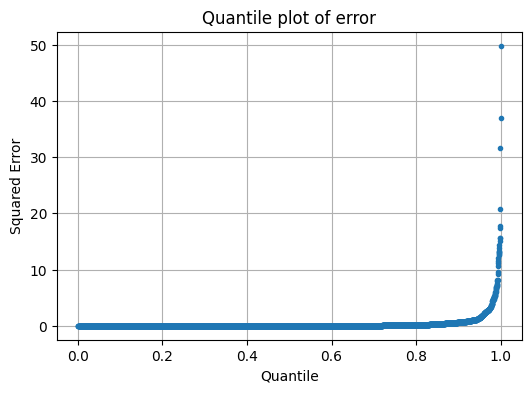

In [30]:
# Trier les données
sorted_error = np.sort(error_df["error"])

# Calculer les quantiles (0 à 1)
quantiles = np.arange(1, len(sorted_error)+1) / len(sorted_error)

# Plot
plt.figure(figsize=(6,4))
plt.plot(quantiles, sorted_error, marker='.', linestyle='none')
plt.xlabel("Quantile")
plt.ylabel("Squared Error")
plt.title("Quantile plot of error")
plt.grid(True)
plt.show()

In [31]:
accuracy = mean_squared_error(Y_test,Y_pred)
print(accuracy)

0.3607032


Dans cette partie, nous avons mis en place différents modèles KDE pour évaluer la densité de probabilité qui correspond à notre distribution

In [ ]:
X_train,Y_train,

In [3]:
print("test push pull")

test push pull


In [5]:
print("git grimpe")

git grimpe


In [ ]:
test n°3099863932